In [1]:
import re
import sys
from time import sleep
from pprint import pprint
from functools import partial

import numpy as np
import optuna
try:
    import pandas as pd
except:
    pass


FILENAME = "main.cpp"

In [2]:
#!cp ../main.cpp ./{FILENAME}

In [3]:
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out
#!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -o {FILENAME}.out

main.cpp:458: warning: ignoring #pragma warning  [-Wunknown-pragmas]
  458 | #pragma warning( disable : 4146 )
      | 
main.cpp: In member function ‘void UltimateEstimator::Step()’:
main.cpp:1149:39: warning: comparison of integer expressions of different signedness: ‘signed char’ and ‘std::array<double, 60>::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
 1149 |   for (auto col = (signed char)0; col < data_x.size(); col++) {
      |                                   ~~~~^~~~~~~~~~~~~~~
main.cpp:1107:8: warning: unused variable ‘estimated_distance’ [-Wunused-variable]
 1107 |   auto estimated_distance = 0.0;
      |        ^~~~~~~~~~~~~~~~~~
main.cpp: In member function ‘void Explorer::Step()’:
main.cpp:1465:30: warning: narrowing conversion of ‘(((int)v.Explorer::Node::y) + 1)’ from ‘int’ to ‘signed char’ [-Wnarrowing]
 1465 |     const auto u = Node{ v.y + (i8)1, v.x, false };
      |                          ~~~~^~~~~~~
main.cpp:1478:35: warning: narrowing conversion of ‘(((

In [4]:
%%time
# もとのスコアの確認
scores = []
for i in range(200):
    i = f"{i:03d}"
    score = !cargo run --release --manifest-path ../tools/Cargo.toml --bin tester in/{i}.txt $(pwd)/{FILENAME}.out 2>&1 | grep Score
    print(i, *score)
    score = int(score[0].split()[-1])
    scores.append(score)
np.mean(scores) / 1e6, np.std(scores) / 1e6

000 Score = 973205472
001 Score = 957379495
002 Score = 973980225
003 Score = 970932090
004 Score = 968803542
005 Score = 973999233
006 Score = 976936034
007 Score = 977650022
008 Score = 970674582
009 Score = 971188022
010 Score = 965499757
011 Score = 969750053
012 Score = 974459127
013 Score = 973940311
014 Score = 966077725
015 Score = 964445009
016 Score = 968933333
017 Score = 959680332
018 Score = 963953227
019 Score = 971471546
020 Score = 962591531
021 Score = 967551748
022 Score = 969721557
023 Score = 964140676
024 Score = 968421502
025 Score = 969535998
026 Score = 961676918
027 Score = 969399505
028 Score = 971495013
029 Score = 967507000
030 Score = 969073649
031 Score = 963983746
032 Score = 970612898
033 Score = 957187428
034 Score = 969879633
035 Score = 967441627
036 Score = 964600453
037 Score = 972578727
038 Score = 959735259
039 Score = 964608698
040 Score = 961468113
041 Score = 973654190
042 Score = 972659616
043 Score = 963363424
044 Score = 974165580
045 Score 

(968.083336095, 6.018865602749576)

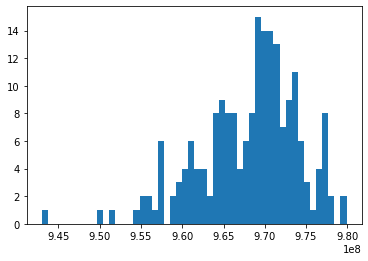

In [5]:
import matplotlib.pyplot as plt
plt.hist(scores, bins=50)
plt.show()

In [2]:
# ここでエラー出力は何かおかしいかもしれない


# パラメータ抽出
with open(FILENAME) as f:
    answer = f.read()


variables_optimize = []

for left, value, right, options in re.findall(r"^([^/\n]*=\s*)(.+?)(\s*;\s*//(?:.*\W)?OPTIMIZE(\W.*))$", answer, re.MULTILINE):
    name = left.replace("=", "").strip().split()[-1]
    
    searched = re.search(r".*\[(?P<min>.*),(?P<max>.*)\].*", options)
    if searched:
        min_value = max_value = None
        try:
            min_value = eval(searched.group("min"))
            max_value = eval(searched.group("max"))
            assert min_value <= max_value
        except Exception as e:
            print(f"searched={searched}", file=sys.stderr)
            print(e, file=sys.stderr)
            continue
        log = "LOG" in options  # 雑、直したほうが良い
        if type(min_value) != type(max_value):
            print(f"searched={searched}", file=sys.stderr)
            print("types not matched", file=sys.stderr)
            continue
        if isinstance(min_value, int):
            method = "suggest_int"
        elif isinstance(min_value, float):
            method = "suggest_float"
        else:
            print(f"searched={searched}", file=sys.stderr)
            print(f"unknown type ({type(min_value)})", file=sys.stderr)
            continue
        variables_optimize.append({
            "name": name,
            "method": method,
            "min": min_value,
            "max": max_value,
            "log": log,
            "left": left,
            "right": right,
        })
    elif searched := re.search(r".*\{(?P<choices>.*?)\}.*", options):
        choices = list(map(lambda x: x.strip(), searched.group("choices").split(",")))
        variables_optimize.append({
            "name": name,
            "method": "suggest_categorical",
            "choices": choices,
            "left": left,
            "right": right,
        })
    else:
        print(f"searched={searched}", file=sys.stderr)
        print(f"pattern was matched but options are incorrect.", file=sys.stderr)

print(len(variables_optimize), "variables were found.")
if globals().get("pd"):
    display(pd.DataFrame(variables_optimize))
else:
    pprint(variables_optimize)

3 variables were found.


,name,method,min,max,log,left,right
0,LAMBDA,suggest_float,2.0,10000.0,True,constexpr double LAMBDA =,"; // OPTIMIZE [2.0, 1e4] LOG"
1,LASSO_LAMBDA,suggest_float,1000.0,1000000.0,True,constexpr double LASSO_LAMBDA =,"; // OPTIMIZE [1e3, 1e6] LOG"
2,RIDGE2_LAMBDA,suggest_float,1.0,10000000.0,True,constexpr double RIDGE2_LAMBDA =,"; // OPTIMIZE [1.0, 1e7] LOG"


In [3]:
def escape(string):  # 正規表現の中でそのまま使いたい文字列をエスケープ
    res = !echo '{string}' | sed -e 's/[]\/$*.^[]/\\&/g'
    return res[0]

def escape_sed(string):  # sed の置換後の文字列用のエスケープ
    res = !echo '{string}' | sed -e 's/[\/&]/\\&/g'
    return res[0]


def objective_with_index(trial, n_internal_parallel):
    index_parallel = trial.number % 10  # これ変数にする
    print(f"{index_parallel=}")
    
    parameters_changed_filename = f"{index_parallel}_{FILENAME}"
    directory_input = "./in"  # "/" をつけない  # 中のすべてのファイルに対して実行される
    
    !mkdir {index_parallel}_out
    !mkdir {index_parallel}_score
    !rm {index_parallel}_out/*
    !rm {index_parallel}_score/*
    
    # ファイル作成
    !cp {FILENAME} {parameters_changed_filename}
    sed_options = [f"-i {parameters_changed_filename}"]
    for variable in variables_optimize:
        if variable["method"] == "suggest_categorical":
            val =  trial.suggest_categorical(variable["name"], variable["choices"])
        else:
            val = getattr(trial, variable["method"])(variable["name"], variable["min"], variable["max"], log=variable["log"])
        left = variable["left"]
        right = variable["right"]
        sed_options.append(f"""-e 's/^{escape(left)}.*{escape(right)}$/{escape_sed(left)}{val}{escape_sed(right)}/'""")
    command_sed = f"sed {' '.join(sed_options)}"
    print(command_sed)
    !{command_sed}
    
    # コンパイル
    command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -DONLINE_JUDGE -o {parameters_changed_filename}.out 2> /dev/null"
    print(command_compile)
    !{command_compile}
    # 実行・採点コマンド (@ はファイル名)
    command_exec = (
        f"cargo run --release --manifest-path ../tools/Cargo.toml --bin tester {directory_input}/@ $(pwd)/{parameters_changed_filename}.out 2>&1 | grep Score | sed -E s/[^0-9]+// > ./{index_parallel}_score/@;"
        #f"./{parameters_changed_filename}.out < {directory_input}/@ > ./{index_parallel}_out/@;"
        #f"cargo run --release --manifest-path ./tools/Cargo.toml --bin vis {directory_input}/@ ./{index_parallel}_out/@ 2> /dev/null > ./{index_parallel}_score/@;"
    )
    # 並列実行 (sed はパスのディレクトリ部分を消してファイル名にしてる)
    !find {directory_input}/* | sed 's!^.*/!!' | xargs -I@ -P {n_internal_parallel} sh -c '{command_exec}'
    
    # 集計
    file_paths = !find ./{index_parallel}_score/*
    sum_score = 0
    for file_path in file_paths:  
        with open(file_path) as f:
            sum_score += int(f.read())
    return sum_score

In [4]:
storage_path = f"study.db"
storage = f"sqlite:///{storage_path}"
study_name = "study"
study = optuna.create_study(storage=storage, load_if_exists=True, study_name=study_name, direction="maximize")

def callback(study, trial):
    try:
        if study.best_value == trial.value:
            print(f"Updated! {study.best_value}")
            index_parallel = trial.number % 10
            parameters_changed_filename = f"{index_parallel}_{FILENAME}"
            !cp {parameters_changed_filename} 00000optimized.cpp
        print("callback ok")
    except:
        print(":(")

objective = partial(objective_with_index, n_internal_parallel=4)
study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=2, callbacks=[callback])

[I 2021-05-30 02:25:03,958] Using an existing study with name 'study' instead of creating a new one.
/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 334.9360800455313;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16743.673367923137;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 343856.87591582857;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/con

[I 2021-05-30 02:26:10,038] Trial 254 finished with value: 193603021699.0 and parameters: {'LAMBDA': 334.9360800455313, 'LASSO_LAMBDA': 16743.673367923137, 'RIDGE2_LAMBDA': 343856.87591582857}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists


[I 2021-05-30 02:26:10,104] Trial 253 finished with value: 193705515763.0 and parameters: {'LAMBDA': 339.6827974287871, 'LASSO_LAMBDA': 18092.969689069254, 'RIDGE2_LAMBDA': 426508.08112657355}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
rm: cannot remove '6_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 285.57555321726613;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14571.064673055747;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 717636.1729701405;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 275.80825944543477;           \/\/

[I 2021-05-30 02:27:12,844] Trial 255 finished with value: 193707901765.0 and parameters: {'LAMBDA': 285.57555321726613, 'LASSO_LAMBDA': 14571.064673055747, 'RIDGE2_LAMBDA': 717636.1729701405}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists


[I 2021-05-30 02:27:12,943] Trial 256 finished with value: 193732399287.0 and parameters: {'LAMBDA': 275.80825944543477, 'LASSO_LAMBDA': 14657.362239696526, 'RIDGE2_LAMBDA': 832407.1656019245}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
rm: cannot remove '8_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 249.82981123762787;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22856.721905881896;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 590517.2918248973;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 272.82704766801885;           \/\/

[I 2021-05-30 02:29:02,338] Trial 257 finished with value: 193415747438.0 and parameters: {'LAMBDA': 249.82981123762787, 'LASSO_LAMBDA': 22856.721905881896, 'RIDGE2_LAMBDA': 590517.2918248973}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 96.98875587907546;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13202.08209750065;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 853204.5185012475;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 02:29:13,741] Trial 258 finished with value: 186293905349.0 and parameters: {'LAMBDA': 272.82704766801885, 'LASSO_LAMBDA': 9777.53886478192, 'RIDGE2_LAMBDA': 914361.1187633942}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 86.00104831978274;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13547.776813643473;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 31151.02539602972;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 02:30:55,481] Trial 259 finished with value: 193173601121.0 and parameters: {'LAMBDA': 96.98875587907546, 'LASSO_LAMBDA': 13202.08209750065, 'RIDGE2_LAMBDA': 853204.5185012475}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 423.5880393599381;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19018.536985201747;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1799444.8733759287;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 02:31:02,780] Trial 260 finished with value: 193447421156.0 and parameters: {'LAMBDA': 86.00104831978274, 'LASSO_LAMBDA': 13547.776813643473, 'RIDGE2_LAMBDA': 31151.02539602972}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 377.97422174172414;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19096.452929505558;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 506064.8337415354;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 02:32:33,444] Trial 261 finished with value: 193653111410.0 and parameters: {'LAMBDA': 423.5880393599381, 'LASSO_LAMBDA': 19018.536985201747, 'RIDGE2_LAMBDA': 1799444.8733759287}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 221.791497596399;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16172.77046195089;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 567829.0574615586;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 02:32:41,251] Trial 262 finished with value: 193641044231.0 and parameters: {'LAMBDA': 377.97422174172414, 'LASSO_LAMBDA': 19096.452929505558, 'RIDGE2_LAMBDA': 506064.8337415354}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 218.35863522185008;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16174.313852113592;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 327741.88087715907;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 02:34:13,824] Trial 263 finished with value: 193670125635.0 and parameters: {'LAMBDA': 221.791497596399, 'LASSO_LAMBDA': 16172.77046195089, 'RIDGE2_LAMBDA': 567829.0574615586}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 306.10398464633823;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11611.271264390683;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 343739.51552721136;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 02:34:22,314] Trial 264 finished with value: 193476432776.0 and parameters: {'LAMBDA': 218.35863522185008, 'LASSO_LAMBDA': 16174.313852113592, 'RIDGE2_LAMBDA': 327741.88087715907}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 290.6503220544012;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 282593.6784859839;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 20604.572802716306;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 02:36:00,655] Trial 265 finished with value: 191986474415.0 and parameters: {'LAMBDA': 306.10398464633823, 'LASSO_LAMBDA': 11611.271264390683, 'RIDGE2_LAMBDA': 343739.51552721136}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory


[I 2021-05-30 02:36:01,214] Trial 266 finished with value: 185954472670.0 and parameters: {'LAMBDA': 290.6503220544012, 'LASSO_LAMBDA': 282593.6784859839, 'RIDGE2_LAMBDA': 20604.572802716306}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 191.19530209941357;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13829.472365382011;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 30066.30508594172;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 112.27260668740142;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e '

[I 2021-05-30 02:37:43,321] Trial 267 finished with value: 193233382105.0 and parameters: {'LAMBDA': 191.19530209941357, 'LASSO_LAMBDA': 13829.472365382011, 'RIDGE2_LAMBDA': 30066.30508594172}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists


[I 2021-05-30 02:37:43,442] Trial 268 finished with value: 192552764371.0 and parameters: {'LAMBDA': 112.27260668740142, 'LASSO_LAMBDA': 14421.33900563686, 'RIDGE2_LAMBDA': 202013.5351426557}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
rm: cannot remove '0_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 144.45142810793774;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18261.076289840043;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1044747.283967511;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 152.0837376588234;           \/\/ 

[I 2021-05-30 02:39:20,843] Trial 270 finished with value: 193635670833.0 and parameters: {'LAMBDA': 152.0837376588234, 'LASSO_LAMBDA': 18068.930109323323, 'RIDGE2_LAMBDA': 1111621.7003379609}. Best is trial 143 with value: 193794133786.0.
[I 2021-05-30 02:39:20,853] Trial 269 finished with value: 193651537563.0 and parameters: {'LAMBDA': 144.45142810793774, 'LASSO_LAMBDA': 18261.076289840043, 'RIDGE2_LAMBDA': 1044747.283967511}. Best is trial 143 with value: 193794133786.0.


callback ok
callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
rm: cannot remove '2_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 187.56988795408378;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10897.812221183629;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 15606.13153978208;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZ

[I 2021-05-30 02:41:01,449] Trial 272 finished with value: 191660725049.0 and parameters: {'LAMBDA': 192.82277574433817, 'LASSO_LAMBDA': 11035.93900933026, 'RIDGE2_LAMBDA': 689347.0865396899}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists


[I 2021-05-30 02:41:01,555] Trial 271 finished with value: 191501159207.0 and parameters: {'LAMBDA': 187.56988795408378, 'LASSO_LAMBDA': 10897.812221183629, 'RIDGE2_LAMBDA': 15606.13153978208}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
rm: cannot remove '4_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 250.23052381334065;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 23674.006040954744;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 38304.602849142626;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 251.8851452181843;           \/\/

[I 2021-05-30 02:42:39,066] Trial 274 finished with value: 193462926861.0 and parameters: {'LAMBDA': 251.8851452181843, 'LASSO_LAMBDA': 22238.102273249777, 'RIDGE2_LAMBDA': 41815.41039397412}. Best is trial 143 with value: 193794133786.0.


callback ok


[I 2021-05-30 02:42:39,160] Trial 273 finished with value: 193392442315.0 and parameters: {'LAMBDA': 250.23052381334065, 'LASSO_LAMBDA': 23674.006040954744, 'RIDGE2_LAMBDA': 38304.602849142626}. Best is trial 143 with value: 193794133786.0.


index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
rm: cannot remove '6_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 80.8629037444485;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15524.484427391502;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1173.3062369644492;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4

[I 2021-05-30 02:44:17,707] Trial 276 finished with value: 193755759288.0 and parameters: {'LAMBDA': 336.40659922392257, 'LASSO_LAMBDA': 15381.774837551473, 'RIDGE2_LAMBDA': 250583.5213877028}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 384.33790601494604;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16015.202815491259;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 259423.78200103185;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 02:44:19,341] Trial 275 finished with value: 193202944221.0 and parameters: {'LAMBDA': 80.8629037444485, 'LASSO_LAMBDA': 15524.484427391502, 'RIDGE2_LAMBDA': 1173.3062369644492}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 393.03058588142056;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12646.046574290329;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 277647.1599005316;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 02:45:56,287] Trial 277 finished with value: 193708858952.0 and parameters: {'LAMBDA': 384.33790601494604, 'LASSO_LAMBDA': 16015.202815491259, 'RIDGE2_LAMBDA': 259423.78200103185}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 540.1212167799896;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 8885.228261126076;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 184366.5670043443;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 02:45:59,847] Trial 278 finished with value: 192208671731.0 and parameters: {'LAMBDA': 393.03058588142056, 'LASSO_LAMBDA': 12646.046574290329, 'RIDGE2_LAMBDA': 277647.1599005316}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 507.9078369312242;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 8713.789413089355;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 172868.94243866348;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 02:47:45,249] Trial 279 finished with value: 181695514634.0 and parameters: {'LAMBDA': 540.1212167799896, 'LASSO_LAMBDA': 8885.228261126076, 'RIDGE2_LAMBDA': 184366.5670043443}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 340.3456839780851;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19460.109811977796;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 441945.6281021565;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 02:47:53,873] Trial 280 finished with value: 177174290874.0 and parameters: {'LAMBDA': 507.9078369312242, 'LASSO_LAMBDA': 8713.789413089355, 'RIDGE2_LAMBDA': 172868.94243866348}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 330.12186296497714;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19401.44909740638;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 418152.6132184709;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 02:49:21,326] Trial 281 finished with value: 193648946432.0 and parameters: {'LAMBDA': 340.3456839780851, 'LASSO_LAMBDA': 19460.109811977796, 'RIDGE2_LAMBDA': 441945.6281021565}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 805.3602507057444;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14416.160002141798;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 418912.9955525964;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 02:49:30,047] Trial 282 finished with value: 193633178055.0 and parameters: {'LAMBDA': 330.12186296497714, 'LASSO_LAMBDA': 19401.44909740638, 'RIDGE2_LAMBDA': 418152.6132184709}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 58.26161544858636;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14571.83128234225;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 702236.72477696;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 02:51:01,764] Trial 283 finished with value: 192088679661.0 and parameters: {'LAMBDA': 805.3602507057444, 'LASSO_LAMBDA': 14416.160002141798, 'RIDGE2_LAMBDA': 418912.9955525964}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 117.34458255352484;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17020.248857821425;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 683617.7738572581;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 02:51:08,634] Trial 284 finished with value: 193719909787.0 and parameters: {'LAMBDA': 58.26161544858636, 'LASSO_LAMBDA': 14571.83128234225, 'RIDGE2_LAMBDA': 702236.72477696}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 37.72550497348786;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12235.133691049463;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2762.9792447509108;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 02:52:39,434] Trial 285 finished with value: 193782172449.0 and parameters: {'LAMBDA': 117.34458255352484, 'LASSO_LAMBDA': 17020.248857821425, 'RIDGE2_LAMBDA': 683617.7738572581}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 105.56380102696693;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17201.379383933956;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3083.126870742352;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 02:52:46,594] Trial 286 finished with value: 193676118972.0 and parameters: {'LAMBDA': 37.72550497348786, 'LASSO_LAMBDA': 12235.133691049463, 'RIDGE2_LAMBDA': 2762.9792447509108}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 114.62811120447435;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20912.405624652754;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1410723.3444075887;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 02:54:17,595] Trial 287 finished with value: 193730672584.0 and parameters: {'LAMBDA': 105.56380102696693, 'LASSO_LAMBDA': 17201.379383933956, 'RIDGE2_LAMBDA': 3083.126870742352}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 103.9045969187806;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17402.02942623977;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 4272.961410228344;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 02:54:24,552] Trial 288 finished with value: 193508065788.0 and parameters: {'LAMBDA': 114.62811120447435, 'LASSO_LAMBDA': 20912.405624652754, 'RIDGE2_LAMBDA': 1410723.3444075887}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 95.37685962770837;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16402.345928696057;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1591.1139237361197;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 02:55:55,583] Trial 289 finished with value: 193708053637.0 and parameters: {'LAMBDA': 103.9045969187806, 'LASSO_LAMBDA': 17402.02942623977, 'RIDGE2_LAMBDA': 4272.961410228344}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 91.20478312702475;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16471.44728529741;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2107.486704401482;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 02:56:02,466] Trial 290 finished with value: 193755543256.0 and parameters: {'LAMBDA': 95.37685962770837, 'LASSO_LAMBDA': 16402.345928696057, 'RIDGE2_LAMBDA': 1591.1139237361197}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 126.63398381519328;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12905.897452009409;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 681149.6392403315;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 02:57:33,260] Trial 291 finished with value: 193790076782.0 and parameters: {'LAMBDA': 91.20478312702475, 'LASSO_LAMBDA': 16471.44728529741, 'RIDGE2_LAMBDA': 2107.486704401482}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 100.01567201922165;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15747.145715637842;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1180.2042605066306;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 02:57:42,075] Trial 292 finished with value: 192447079234.0 and parameters: {'LAMBDA': 126.63398381519328, 'LASSO_LAMBDA': 12905.897452009409, 'RIDGE2_LAMBDA': 681149.6392403315}. Best is trial 143 with value: 193794133786.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.506582321311223;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 26376.66026604972;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1597.29594768018;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 02:59:11,534] Trial 293 finished with value: 193812768975.0 and parameters: {'LAMBDA': 100.01567201922165, 'LASSO_LAMBDA': 15747.145715637842, 'RIDGE2_LAMBDA': 1180.2042605066306}. Best is trial 293 with value: 193812768975.0.


Updated! 193812768975.0
callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 89.9868916342416;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15896.9959830677;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1794.8030882087703;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 02:59:20,291] Trial 294 finished with value: 193171080694.0 and parameters: {'LAMBDA': 14.506582321311223, 'LASSO_LAMBDA': 26376.66026604972, 'RIDGE2_LAMBDA': 1597.29594768018}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 93.30691703910053;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15553.31698091284;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1146.2431906171958;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:00:52,114] Trial 295 finished with value: 193213547541.0 and parameters: {'LAMBDA': 89.9868916342416, 'LASSO_LAMBDA': 15896.9959830677, 'RIDGE2_LAMBDA': 1794.8030882087703}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 98.65056608024489;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20697.530767209802;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 736.8722968148038;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:01:00,744] Trial 296 finished with value: 193172318877.0 and parameters: {'LAMBDA': 93.30691703910053, 'LASSO_LAMBDA': 15553.31698091284, 'RIDGE2_LAMBDA': 1146.2431906171958}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 107.3420203787805;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20513.000224801683;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1437.1660359761536;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:02:29,635] Trial 297 finished with value: 193511619152.0 and parameters: {'LAMBDA': 98.65056608024489, 'LASSO_LAMBDA': 20697.530767209802, 'RIDGE2_LAMBDA': 736.8722968148038}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 111.76705525634299;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10066.328883915172;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 934094.6089830498;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:02:38,333] Trial 298 finished with value: 193580087451.0 and parameters: {'LAMBDA': 107.3420203787805, 'LASSO_LAMBDA': 20513.000224801683, 'RIDGE2_LAMBDA': 1437.1660359761536}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 78.7665683098152;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10201.187002834648;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 575.6038777780677;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:04:12,180] Trial 299 finished with value: 190489077588.0 and parameters: {'LAMBDA': 111.76705525634299, 'LASSO_LAMBDA': 10066.328883915172, 'RIDGE2_LAMBDA': 934094.6089830498}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 79.02602115942135;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11769.272118325878;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2360.9810991313225;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:04:18,889] Trial 300 finished with value: 191751658928.0 and parameters: {'LAMBDA': 78.7665683098152, 'LASSO_LAMBDA': 10201.187002834648, 'RIDGE2_LAMBDA': 575.6038777780677}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 73.86221512192314;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12628.202914538868;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2500.812924546714;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:05:51,057] Trial 301 finished with value: 193499364453.0 and parameters: {'LAMBDA': 79.02602115942135, 'LASSO_LAMBDA': 11769.272118325878, 'RIDGE2_LAMBDA': 2360.9810991313225}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 127.2079435948709;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14116.291001275207;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1952951.1450582854;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:05:58,908] Trial 302 finished with value: 193408669679.0 and parameters: {'LAMBDA': 73.86221512192314, 'LASSO_LAMBDA': 12628.202914538868, 'RIDGE2_LAMBDA': 2500.812924546714}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 135.85263269091539;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17316.5398838666;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1064.7999581213996;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:07:30,888] Trial 303 finished with value: 193220058942.0 and parameters: {'LAMBDA': 127.2079435948709, 'LASSO_LAMBDA': 14116.291001275207, 'RIDGE2_LAMBDA': 1952951.1450582854}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 135.83192183779983;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17631.374285655507;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1121.1211316645279;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:07:37,408] Trial 304 finished with value: 193684721037.0 and parameters: {'LAMBDA': 135.85263269091539, 'LASSO_LAMBDA': 17316.5398838666, 'RIDGE2_LAMBDA': 1064.7999581213996}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 163.60134649047265;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15050.41891969535;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 533261.3612412021;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:09:08,953] Trial 305 finished with value: 193672240290.0 and parameters: {'LAMBDA': 135.83192183779983, 'LASSO_LAMBDA': 17631.374285655507, 'RIDGE2_LAMBDA': 1121.1211316645279}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 170.44017212275935;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15395.651106676904;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 281241.54397307837;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:09:15,273] Trial 306 finished with value: 193788282555.0 and parameters: {'LAMBDA': 163.60134649047265, 'LASSO_LAMBDA': 15050.41891969535, 'RIDGE2_LAMBDA': 533261.3612412021}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 172.3201467119877;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13426.13837351093;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 317859.06175358663;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:10:50,574] Trial 307 finished with value: 193746843416.0 and parameters: {'LAMBDA': 170.44017212275935, 'LASSO_LAMBDA': 15395.651106676904, 'RIDGE2_LAMBDA': 281241.54397307837}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 169.2217458874484;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12732.164556353448;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 682038.9292712958;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:10:58,957] Trial 308 finished with value: 193688792776.0 and parameters: {'LAMBDA': 172.3201467119877, 'LASSO_LAMBDA': 13426.13837351093, 'RIDGE2_LAMBDA': 317859.06175358663}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 155.00417800693458;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12331.533444029226;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 619479.4474270528;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:12:43,470] Trial 309 finished with value: 192646063277.0 and parameters: {'LAMBDA': 169.2217458874484, 'LASSO_LAMBDA': 12732.164556353448, 'RIDGE2_LAMBDA': 682038.9292712958}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 158.44208937077434;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15091.370408671672;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 538881.8015283117;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:12:49,344] Trial 310 finished with value: 193714138113.0 and parameters: {'LAMBDA': 155.00417800693458, 'LASSO_LAMBDA': 12331.533444029226, 'RIDGE2_LAMBDA': 619479.4474270528}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 121.4367461346844;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15018.494758958846;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1083009.4150376203;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:14:33,306] Trial 311 finished with value: 193716922663.0 and parameters: {'LAMBDA': 158.44208937077434, 'LASSO_LAMBDA': 15091.370408671672, 'RIDGE2_LAMBDA': 538881.8015283117}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 126.67440779256536;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11157.878084803207;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1105482.1312211812;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:14:40,287] Trial 312 finished with value: 193128846984.0 and parameters: {'LAMBDA': 121.4367461346844, 'LASSO_LAMBDA': 15018.494758958846, 'RIDGE2_LAMBDA': 1083009.4150376203}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 437.91610806644627;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11250.715107619042;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 380597.041188655;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:16:29,272] Trial 313 finished with value: 191213670165.0 and parameters: {'LAMBDA': 126.67440779256536, 'LASSO_LAMBDA': 11157.878084803207, 'RIDGE2_LAMBDA': 1105482.1312211812}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 228.79367585789626;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14052.744061477346;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 381851.8461347109;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:16:40,595] Trial 314 finished with value: 189030952094.0 and parameters: {'LAMBDA': 437.91610806644627, 'LASSO_LAMBDA': 11250.715107619042, 'RIDGE2_LAMBDA': 380597.041188655}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 226.1990362350123;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14009.249779387688;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 285744.2687267253;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:18:11,826] Trial 315 finished with value: 193762239241.0 and parameters: {'LAMBDA': 228.79367585789626, 'LASSO_LAMBDA': 14052.744061477346, 'RIDGE2_LAMBDA': 381851.8461347109}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 187.39057260739872;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13785.050970285973;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 412.98960503614234;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:18:20,805] Trial 316 finished with value: 193756539068.0 and parameters: {'LAMBDA': 226.1990362350123, 'LASSO_LAMBDA': 14009.249779387688, 'RIDGE2_LAMBDA': 285744.2687267253}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 194.4941822592297;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13417.812535758103;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 324547.5060946107;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:19:53,029] Trial 317 finished with value: 193676309062.0 and parameters: {'LAMBDA': 187.39057260739872, 'LASSO_LAMBDA': 13785.050970285973, 'RIDGE2_LAMBDA': 412.98960503614234}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 224.2345755292157;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 9535.01863393336;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 429975.48024631233;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:20:02,475] Trial 318 finished with value: 193729042422.0 and parameters: {'LAMBDA': 194.4941822592297, 'LASSO_LAMBDA': 13417.812535758103, 'RIDGE2_LAMBDA': 324547.5060946107}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 237.69450323465378;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 9286.095445857269;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 459185.22178481275;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:21:41,795] Trial 319 finished with value: 186800588102.0 and parameters: {'LAMBDA': 224.2345755292157, 'LASSO_LAMBDA': 9535.01863393336, 'RIDGE2_LAMBDA': 429975.48024631233}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 179.13141878144663;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11890.865057378844;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 260416.07226306043;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:21:50,978] Trial 320 finished with value: 185570378693.0 and parameters: {'LAMBDA': 237.69450323465378, 'LASSO_LAMBDA': 9286.095445857269, 'RIDGE2_LAMBDA': 459185.22178481275}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 147.97323311741704;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12039.170531619258;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 304385.50380734325;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:23:22,592] Trial 321 finished with value: 193647483521.0 and parameters: {'LAMBDA': 179.13141878144663, 'LASSO_LAMBDA': 11890.865057378844, 'RIDGE2_LAMBDA': 260416.07226306043}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 146.54064987686166;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18524.447662026247;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 53634.73290963333;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:23:31,491] Trial 322 finished with value: 193745357451.0 and parameters: {'LAMBDA': 147.97323311741704, 'LASSO_LAMBDA': 12039.170531619258, 'RIDGE2_LAMBDA': 304385.50380734325}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 152.81997579799244;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10805.999096893196;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 300800.625167313;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:25:01,818] Trial 323 finished with value: 193644302699.0 and parameters: {'LAMBDA': 146.54064987686166, 'LASSO_LAMBDA': 18524.447662026247, 'RIDGE2_LAMBDA': 53634.73290963333}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 149.57003983901333;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10704.775550390368;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 288525.18178528396;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:25:12,863] Trial 324 finished with value: 191441674559.0 and parameters: {'LAMBDA': 152.81997579799244, 'LASSO_LAMBDA': 10805.999096893196, 'RIDGE2_LAMBDA': 300800.625167313}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 115.53237900769064;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 23720.539188619074;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 524381.3518780943;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:26:42,994] Trial 325 finished with value: 191925715867.0 and parameters: {'LAMBDA': 149.57003983901333, 'LASSO_LAMBDA': 10704.775550390368, 'RIDGE2_LAMBDA': 288525.18178528396}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 107.38093711820655;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 23591.25533149206;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 534396.3914679594;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:26:51,904] Trial 326 finished with value: 193389749392.0 and parameters: {'LAMBDA': 115.53237900769064, 'LASSO_LAMBDA': 23720.539188619074, 'RIDGE2_LAMBDA': 524381.3518780943}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 213.55842675662166;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15507.30700792009;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 359696.40783452184;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:28:26,365] Trial 327 finished with value: 193398340416.0 and parameters: {'LAMBDA': 107.38093711820655, 'LASSO_LAMBDA': 23591.25533149206, 'RIDGE2_LAMBDA': 534396.3914679594}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 209.14954881419916;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15504.18707204042;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 231850.12301421873;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:28:38,204] Trial 328 finished with value: 193092230948.0 and parameters: {'LAMBDA': 213.55842675662166, 'LASSO_LAMBDA': 15507.30700792009, 'RIDGE2_LAMBDA': 359696.40783452184}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 183.00061166923618;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12418.91645273908;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 216717.73064228005;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:30:16,729] Trial 329 finished with value: 193671886888.0 and parameters: {'LAMBDA': 209.14954881419916, 'LASSO_LAMBDA': 15504.18707204042, 'RIDGE2_LAMBDA': 231850.12301421873}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 174.83185712945422;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12590.944004359642;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 697769.283799801;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:30:36,427] Trial 330 finished with value: 192791508906.0 and parameters: {'LAMBDA': 183.00061166923618, 'LASSO_LAMBDA': 12418.91645273908, 'RIDGE2_LAMBDA': 216717.73064228005}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 92.55710601438335;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19410.878221238425;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 802331.8417029169;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:32:20,477] Trial 331 finished with value: 193652559563.0 and parameters: {'LAMBDA': 174.83185712945422, 'LASSO_LAMBDA': 12590.944004359642, 'RIDGE2_LAMBDA': 697769.283799801}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 130.96341114376966;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18981.555529591507;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 406698.5350536848;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:32:33,019] Trial 332 finished with value: 193520237015.0 and parameters: {'LAMBDA': 92.55710601438335, 'LASSO_LAMBDA': 19410.878221238425, 'RIDGE2_LAMBDA': 802331.8417029169}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 129.72989833041441;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14204.328724378616;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 347419.8115590538;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:34:17,070] Trial 333 finished with value: 193600307457.0 and parameters: {'LAMBDA': 130.96341114376966, 'LASSO_LAMBDA': 18981.555529591507, 'RIDGE2_LAMBDA': 406698.5350536848}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 283.6883992115526;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14291.468724071168;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1330461.4248780855;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:34:31,513] Trial 334 finished with value: 193179774038.0 and parameters: {'LAMBDA': 129.72989833041441, 'LASSO_LAMBDA': 14204.328724378616, 'RIDGE2_LAMBDA': 347419.8115590538}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 283.46506740238675;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 7672.44120082136;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 157795.93977982822;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:36:15,171] Trial 335 finished with value: 193203691927.0 and parameters: {'LAMBDA': 283.6883992115526, 'LASSO_LAMBDA': 14291.468724071168, 'RIDGE2_LAMBDA': 1330461.4248780855}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 232.53880559511805;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16932.587881039875;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1529.3674756451446;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:36:43,317] Trial 336 finished with value: 178771628618.0 and parameters: {'LAMBDA': 283.46506740238675, 'LASSO_LAMBDA': 7672.44120082136, 'RIDGE2_LAMBDA': 157795.93977982822}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 238.63821595674236;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16905.725176539454;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 762.1972972408042;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:38:01,126] Trial 337 finished with value: 193658665227.0 and parameters: {'LAMBDA': 232.53880559511805, 'LASSO_LAMBDA': 16932.587881039875, 'RIDGE2_LAMBDA': 1529.3674756451446}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 170.5626292749422;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11549.826627250965;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 529149.3869469571;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:38:28,402] Trial 338 finished with value: 193715495042.0 and parameters: {'LAMBDA': 238.63821595674236, 'LASSO_LAMBDA': 16905.725176539454, 'RIDGE2_LAMBDA': 762.1972972408042}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 164.177300480965;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10223.749779207958;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 606283.7573526632;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:39:43,620] Trial 339 finished with value: 192688465439.0 and parameters: {'LAMBDA': 170.5626292749422, 'LASSO_LAMBDA': 11549.826627250965, 'RIDGE2_LAMBDA': 529149.3869469571}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 146.14072930616194;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 21306.493285692595;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2055584.5228023175;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:40:09,707] Trial 340 finished with value: 191408715509.0 and parameters: {'LAMBDA': 164.177300480965, 'LASSO_LAMBDA': 10223.749779207958, 'RIDGE2_LAMBDA': 606283.7573526632}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 91.99159932048285;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 21362.259711658022;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1768109.9378026717;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:41:20,307] Trial 341 finished with value: 193480184623.0 and parameters: {'LAMBDA': 146.14072930616194, 'LASSO_LAMBDA': 21306.493285692595, 'RIDGE2_LAMBDA': 2055584.5228023175}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 87.02086141260148;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14109.546977293801;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 265515.99760434736;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:41:47,154] Trial 342 finished with value: 193487329583.0 and parameters: {'LAMBDA': 91.99159932048285, 'LASSO_LAMBDA': 21362.259711658022, 'RIDGE2_LAMBDA': 1768109.9378026717}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 121.95530656202921;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13844.7973596484;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 846596.43591526;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:42:59,787] Trial 343 finished with value: 193803712479.0 and parameters: {'LAMBDA': 87.02086141260148, 'LASSO_LAMBDA': 14109.546977293801, 'RIDGE2_LAMBDA': 265515.99760434736}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 68.06600046531177;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13056.084939706017;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 277279.7568182943;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:43:28,001] Trial 344 finished with value: 193184788789.0 and parameters: {'LAMBDA': 121.95530656202921, 'LASSO_LAMBDA': 13844.7973596484, 'RIDGE2_LAMBDA': 846596.43591526}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 69.06066485400298;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16029.25307260254;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 237258.5643198524;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:44:37,912] Trial 345 finished with value: 193732304920.0 and parameters: {'LAMBDA': 68.06600046531177, 'LASSO_LAMBDA': 13056.084939706017, 'RIDGE2_LAMBDA': 277279.7568182943}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 81.8941031571112;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16190.090300634798;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 196799.63688160127;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:45:06,231] Trial 346 finished with value: 193749782978.0 and parameters: {'LAMBDA': 69.06066485400298, 'LASSO_LAMBDA': 16029.25307260254, 'RIDGE2_LAMBDA': 237258.5643198524}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 71.58535132144439;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17819.394862949168;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 139855.62450232884;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:46:15,582] Trial 347 finished with value: 193764953974.0 and parameters: {'LAMBDA': 81.8941031571112, 'LASSO_LAMBDA': 16190.090300634798, 'RIDGE2_LAMBDA': 196799.63688160127}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 76.94260163871832;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18498.658845517064;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 135124.0369775067;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:46:44,310] Trial 348 finished with value: 193600793790.0 and parameters: {'LAMBDA': 71.58535132144439, 'LASSO_LAMBDA': 17819.394862949168, 'RIDGE2_LAMBDA': 139855.62450232884}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 76.77802970661648;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18794.492590156377;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 199541.12432076834;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:47:53,585] Trial 349 finished with value: 193640456572.0 and parameters: {'LAMBDA': 76.94260163871832, 'LASSO_LAMBDA': 18498.658845517064, 'RIDGE2_LAMBDA': 135124.0369775067}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 91.79884128939426;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15184.658957374066;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 188371.41479104344;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:48:22,288] Trial 350 finished with value: 193645210187.0 and parameters: {'LAMBDA': 76.77802970661648, 'LASSO_LAMBDA': 18794.492590156377, 'RIDGE2_LAMBDA': 199541.12432076834}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 101.35555167666097;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16428.632001772363;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 166542.04992607379;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:49:32,253] Trial 351 finished with value: 193244761671.0 and parameters: {'LAMBDA': 91.79884128939426, 'LASSO_LAMBDA': 15184.658957374066, 'RIDGE2_LAMBDA': 188371.41479104344}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 58.717900560183125;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16013.546872092034;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 112642.88508938366;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:49:58,796] Trial 352 finished with value: 193747787985.0 and parameters: {'LAMBDA': 101.35555167666097, 'LASSO_LAMBDA': 16428.632001772363, 'RIDGE2_LAMBDA': 166542.04992607379}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 88.59479596724293;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 27874.183432486643;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 95896.16022792857;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:51:09,463] Trial 353 finished with value: 193656074537.0 and parameters: {'LAMBDA': 58.717900560183125, 'LASSO_LAMBDA': 16013.546872092034, 'RIDGE2_LAMBDA': 112642.88508938366}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 91.56973394772191;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 25056.373238772918;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 233187.9944493494;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:51:35,725] Trial 354 finished with value: 193187785018.0 and parameters: {'LAMBDA': 88.59479596724293, 'LASSO_LAMBDA': 27874.183432486643, 'RIDGE2_LAMBDA': 95896.16022792857}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 98.9513171712113;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11979.658566048085;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 231326.71626274902;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:52:47,219] Trial 355 finished with value: 193324555170.0 and parameters: {'LAMBDA': 91.56973394772191, 'LASSO_LAMBDA': 25056.373238772918, 'RIDGE2_LAMBDA': 233187.9944493494}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 104.06980433878822;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20724.797757413733;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 166511.2931554745;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:53:14,747] Trial 356 finished with value: 192489427243.0 and parameters: {'LAMBDA': 98.9513171712113, 'LASSO_LAMBDA': 11979.658566048085, 'RIDGE2_LAMBDA': 231326.71626274902}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 80.68230624334544;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19830.293622386947;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 157383.84891404636;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:54:26,885] Trial 357 finished with value: 193538787145.0 and parameters: {'LAMBDA': 104.06980433878822, 'LASSO_LAMBDA': 20724.797757413733, 'RIDGE2_LAMBDA': 166511.2931554745}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 66.33721805027876;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16903.941985991987;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 133649.10088191627;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:54:54,044] Trial 358 finished with value: 193598538993.0 and parameters: {'LAMBDA': 80.68230624334544, 'LASSO_LAMBDA': 19830.293622386947, 'RIDGE2_LAMBDA': 157383.84891404636}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 61.55528141462261;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16334.860765630063;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 72985.6376214369;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:56:04,918] Trial 359 finished with value: 193685777486.0 and parameters: {'LAMBDA': 66.33721805027876, 'LASSO_LAMBDA': 16903.941985991987, 'RIDGE2_LAMBDA': 133649.10088191627}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 113.12000644344295;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12731.857333077915;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 63955.430312459896;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:56:32,140] Trial 360 finished with value: 193678320916.0 and parameters: {'LAMBDA': 61.55528141462261, 'LASSO_LAMBDA': 16334.860765630063, 'RIDGE2_LAMBDA': 72985.6376214369}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 111.04704254972877;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12807.416136591455;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 276609.4380515949;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:57:43,912] Trial 361 finished with value: 192257604019.0 and parameters: {'LAMBDA': 113.12000644344295, 'LASSO_LAMBDA': 12731.857333077915, 'RIDGE2_LAMBDA': 63955.430312459896}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 88.24009261342866;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 9005.16680890365;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 312110.2442553944;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:58:10,953] Trial 362 finished with value: 192811465897.0 and parameters: {'LAMBDA': 111.04704254972877, 'LASSO_LAMBDA': 12807.416136591455, 'RIDGE2_LAMBDA': 276609.4380515949}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 77.434130849852;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 9500.015320446379;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 295804.9208584946;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:59:25,917] Trial 363 finished with value: 189272357008.0 and parameters: {'LAMBDA': 88.24009261342866, 'LASSO_LAMBDA': 9005.16680890365, 'RIDGE2_LAMBDA': 312110.2442553944}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 71.50305727346723;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 3071.19800307994;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 227508.80587964584;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:59:51,165] Trial 364 finished with value: 191405853075.0 and parameters: {'LAMBDA': 77.434130849852, 'LASSO_LAMBDA': 9500.015320446379, 'RIDGE2_LAMBDA': 295804.9208584946}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 102.25917183248707;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16196.857358839532;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 177772.64649209424;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:01:28,389] Trial 366 finished with value: 193769034614.0 and parameters: {'LAMBDA': 102.25917183248707, 'LASSO_LAMBDA': 16196.857358839532, 'RIDGE2_LAMBDA': 177772.64649209424}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 73.17378258497746;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17830.059658918482;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 192665.56802914792;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:01:55,681] Trial 365 finished with value: 132634701840.0 and parameters: {'LAMBDA': 71.50305727346723, 'LASSO_LAMBDA': 3071.19800307994, 'RIDGE2_LAMBDA': 227508.80587964584}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 98.91190042891972;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18445.306723249167;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 109936.28899263837;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:03:05,096] Trial 367 finished with value: 193591754018.0 and parameters: {'LAMBDA': 73.17378258497746, 'LASSO_LAMBDA': 17830.059658918482, 'RIDGE2_LAMBDA': 192665.56802914792}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 109.01840290523013;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22230.63207355516;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 134093.55955785242;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:03:34,164] Trial 368 finished with value: 193593923815.0 and parameters: {'LAMBDA': 98.91190042891972, 'LASSO_LAMBDA': 18445.306723249167, 'RIDGE2_LAMBDA': 109936.28899263837}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 103.2265852126403;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11291.193505382447;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 135179.36547186878;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:04:44,185] Trial 369 finished with value: 193498411040.0 and parameters: {'LAMBDA': 109.01840290523013, 'LASSO_LAMBDA': 22230.63207355516, 'RIDGE2_LAMBDA': 134093.55955785242}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 84.6472585397308;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14116.079467459516;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 186923.6749925637;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:05:16,378] Trial 370 finished with value: 190428530897.0 and parameters: {'LAMBDA': 103.2265852126403, 'LASSO_LAMBDA': 11291.193505382447, 'RIDGE2_LAMBDA': 135179.36547186878}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 54.019693439444374;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 136761.22525913193;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 85712.29448751612;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:06:21,038] Trial 371 finished with value: 193789636345.0 and parameters: {'LAMBDA': 84.6472585397308, 'LASSO_LAMBDA': 14116.079467459516, 'RIDGE2_LAMBDA': 186923.6749925637}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 53.4826668822958;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13933.56480561457;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 247192.52073289943;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:06:52,718] Trial 372 finished with value: 189777878283.0 and parameters: {'LAMBDA': 54.019693439444374, 'LASSO_LAMBDA': 136761.22525913193, 'RIDGE2_LAMBDA': 85712.29448751612}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 87.32011257826318;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14131.567250891367;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 190035.4375474166;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:07:59,343] Trial 373 finished with value: 193704133065.0 and parameters: {'LAMBDA': 53.4826668822958, 'LASSO_LAMBDA': 13933.56480561457, 'RIDGE2_LAMBDA': 247192.52073289943}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 87.77827820448078;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11128.880521311297;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 199644.83939510802;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:08:31,760] Trial 374 finished with value: 193795346348.0 and parameters: {'LAMBDA': 87.32011257826318, 'LASSO_LAMBDA': 14131.567250891367, 'RIDGE2_LAMBDA': 190035.4375474166}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 88.3876265691076;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15616.779635655266;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 181384.71917232816;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:09:38,910] Trial 375 finished with value: 192956339554.0 and parameters: {'LAMBDA': 87.77827820448078, 'LASSO_LAMBDA': 11128.880521311297, 'RIDGE2_LAMBDA': 199644.83939510802}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 80.90127772570081;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15797.64990931723;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 164349.37624523172;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:10:11,252] Trial 376 finished with value: 193152801812.0 and parameters: {'LAMBDA': 88.3876265691076, 'LASSO_LAMBDA': 15616.779635655266, 'RIDGE2_LAMBDA': 181384.71917232816}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 121.0669189125135;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13899.136714283897;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 160523.01630957134;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:11:22,706] Trial 377 finished with value: 193768517587.0 and parameters: {'LAMBDA': 80.90127772570081, 'LASSO_LAMBDA': 15797.64990931723, 'RIDGE2_LAMBDA': 164349.37624523172}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 62.90599989478089;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 31621.621334326115;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 135208.64214711532;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:11:59,553] Trial 378 finished with value: 193128562582.0 and parameters: {'LAMBDA': 121.0669189125135, 'LASSO_LAMBDA': 13899.136714283897, 'RIDGE2_LAMBDA': 160523.01630957134}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 63.75637433581733;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17492.432330871477;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 115684.16430670944;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:13:12,783] Trial 379 finished with value: 192934182645.0 and parameters: {'LAMBDA': 62.90599989478089, 'LASSO_LAMBDA': 31621.621334326115, 'RIDGE2_LAMBDA': 135208.64214711532}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 71.45895576107182;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16554.163519347556;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 265070.8467951677;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:13:49,299] Trial 380 finished with value: 193609284930.0 and parameters: {'LAMBDA': 63.75637433581733, 'LASSO_LAMBDA': 17492.432330871477, 'RIDGE2_LAMBDA': 115684.16430670944}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 76.02808065317068;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20963.158012315605;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 218075.1492141269;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:14:59,361] Trial 381 finished with value: 193716776573.0 and parameters: {'LAMBDA': 71.45895576107182, 'LASSO_LAMBDA': 16554.163519347556, 'RIDGE2_LAMBDA': 265070.8467951677}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 85.84440396846978;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19669.013720637697;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 203923.10295609455;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:15:36,584] Trial 382 finished with value: 193481330865.0 and parameters: {'LAMBDA': 76.02808065317068, 'LASSO_LAMBDA': 20963.158012315605, 'RIDGE2_LAMBDA': 218075.1492141269}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 97.77470489600262;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13145.875387164693;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 306777.86490686616;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:16:49,199] Trial 383 finished with value: 193538239308.0 and parameters: {'LAMBDA': 85.84440396846978, 'LASSO_LAMBDA': 19669.013720637697, 'RIDGE2_LAMBDA': 203923.10295609455}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 103.06573029924935;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12900.217460496235;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 324871.8249254509;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:17:24,469] Trial 384 finished with value: 192973729468.0 and parameters: {'LAMBDA': 97.77470489600262, 'LASSO_LAMBDA': 13145.875387164693, 'RIDGE2_LAMBDA': 306777.86490686616}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 119.84077667426212;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 1173.2897130349286;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 356506.1705743032;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:18:31,735] Trial 385 finished with value: 192657229255.0 and parameters: {'LAMBDA': 103.06573029924935, 'LASSO_LAMBDA': 12900.217460496235, 'RIDGE2_LAMBDA': 324871.8249254509}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 132.90893123606628;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15122.805251395192;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 171439.58051947315;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:20:09,604] Trial 387 finished with value: 193647874709.0 and parameters: {'LAMBDA': 132.90893123606628, 'LASSO_LAMBDA': 15122.805251395192, 'RIDGE2_LAMBDA': 171439.58051947315}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 119.60241768432374;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16190.067430553325;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 113117.26587723836;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:20:33,328] Trial 386 finished with value: 80210599543.0 and parameters: {'LAMBDA': 119.84077667426212, 'LASSO_LAMBDA': 1173.2897130349286, 'RIDGE2_LAMBDA': 356506.1705743032}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 84.07410186960864;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 500581.9760652225;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 90740.0625279179;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:21:49,255] Trial 388 finished with value: 193729212388.0 and parameters: {'LAMBDA': 119.60241768432374, 'LASSO_LAMBDA': 16190.067430553325, 'RIDGE2_LAMBDA': 113117.26587723836}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 83.45628951379561;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 532855.3803695625;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 247986.77952004765;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:22:12,147] Trial 389 finished with value: 185746817797.0 and parameters: {'LAMBDA': 84.07410186960864, 'LASSO_LAMBDA': 500581.9760652225, 'RIDGE2_LAMBDA': 90740.0625279179}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 97.57637933085138;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22903.711655586794;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 252418.4726489671;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:23:29,331] Trial 390 finished with value: 185594275482.0 and parameters: {'LAMBDA': 83.45628951379561, 'LASSO_LAMBDA': 532855.3803695625, 'RIDGE2_LAMBDA': 247986.77952004765}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 65.28533098161273;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14316.085888243822;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 177807.9131225001;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:23:51,145] Trial 391 finished with value: 193400715266.0 and parameters: {'LAMBDA': 97.57637933085138, 'LASSO_LAMBDA': 22903.711655586794, 'RIDGE2_LAMBDA': 252418.4726489671}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 74.23764508213134;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18092.997361320642;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 159203.24189929976;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:25:13,005] Trial 392 finished with value: 193284729640.0 and parameters: {'LAMBDA': 65.28533098161273, 'LASSO_LAMBDA': 14316.085888243822, 'RIDGE2_LAMBDA': 177807.9131225001}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 107.9560359984114;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18663.16127776376;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 380033.8389421486;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:25:39,179] Trial 393 finished with value: 193663663816.0 and parameters: {'LAMBDA': 74.23764508213134, 'LASSO_LAMBDA': 18092.997361320642, 'RIDGE2_LAMBDA': 159203.24189929976}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 135.22465529174804;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11932.915783365552;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1463.5563836616075;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:27:12,433] Trial 394 finished with value: 193628792647.0 and parameters: {'LAMBDA': 107.9560359984114, 'LASSO_LAMBDA': 18663.16127776376, 'RIDGE2_LAMBDA': 380033.8389421486}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 127.64842751485853;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11852.733678236815;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1836.6161138615664;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:27:37,069] Trial 395 finished with value: 192483793703.0 and parameters: {'LAMBDA': 135.22465529174804, 'LASSO_LAMBDA': 11932.915783365552, 'RIDGE2_LAMBDA': 1463.5563836616075}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 95.83569183635812;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16332.252915903468;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 368060.44704050885;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:29:14,503] Trial 396 finished with value: 192448716182.0 and parameters: {'LAMBDA': 127.64842751485853, 'LASSO_LAMBDA': 11852.733678236815, 'RIDGE2_LAMBDA': 1836.6161138615664}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 92.49654351762963;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14939.526837250109;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 385843.2631714123;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:29:42,746] Trial 397 finished with value: 193135991254.0 and parameters: {'LAMBDA': 95.83569183635812, 'LASSO_LAMBDA': 16332.252915903468, 'RIDGE2_LAMBDA': 368060.44704050885}. Best is trial 293 with value: 193812768975.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 112.26437286670735;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14189.659970440889;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 220190.49689530692;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:31:20,005] Trial 398 finished with value: 193816408796.0 and parameters: {'LAMBDA': 92.49654351762963, 'LASSO_LAMBDA': 14939.526837250109, 'RIDGE2_LAMBDA': 385843.2631714123}. Best is trial 398 with value: 193816408796.0.


Updated! 193816408796.0
callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 73.6680356750742;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15151.167487522845;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 403257.08775685844;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:31:49,201] Trial 399 finished with value: 193090893842.0 and parameters: {'LAMBDA': 112.26437286670735, 'LASSO_LAMBDA': 14189.659970440889, 'RIDGE2_LAMBDA': 220190.49689530692}. Best is trial 398 with value: 193816408796.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 79.82885678723282;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20231.598753056256;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 102248.98311302565;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:33:22,319] Trial 400 finished with value: 193796924350.0 and parameters: {'LAMBDA': 73.6680356750742, 'LASSO_LAMBDA': 15151.167487522845, 'RIDGE2_LAMBDA': 403257.08775685844}. Best is trial 398 with value: 193816408796.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 67.65650478318629;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 24864.781626289696;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 877.6221900748195;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:33:45,840] Trial 401 finished with value: 193586080778.0 and parameters: {'LAMBDA': 79.82885678723282, 'LASSO_LAMBDA': 20231.598753056256, 'RIDGE2_LAMBDA': 102248.98311302565}. Best is trial 398 with value: 193816408796.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 68.500857617835;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16927.22860207081;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 421298.77726454416;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:35:03,283] Trial 402 finished with value: 193321982556.0 and parameters: {'LAMBDA': 67.65650478318629, 'LASSO_LAMBDA': 24864.781626289696, 'RIDGE2_LAMBDA': 877.6221900748195}. Best is trial 398 with value: 193816408796.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 63.59779517651168;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16822.462458718972;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 435927.9668180774;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:35:27,752] Trial 403 finished with value: 193643750098.0 and parameters: {'LAMBDA': 68.500857617835, 'LASSO_LAMBDA': 16927.22860207081, 'RIDGE2_LAMBDA': 421298.77726454416}. Best is trial 398 with value: 193816408796.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 84.36742257747466;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14156.317143210023;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 419815.5044504559;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:36:46,055] Trial 404 finished with value: 193653059879.0 and parameters: {'LAMBDA': 63.59779517651168, 'LASSO_LAMBDA': 16822.462458718972, 'RIDGE2_LAMBDA': 435927.9668180774}. Best is trial 398 with value: 193816408796.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 55.92897015678963;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14229.309251336092;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 129221.99563898743;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:37:09,972] Trial 405 finished with value: 193775780909.0 and parameters: {'LAMBDA': 84.36742257747466, 'LASSO_LAMBDA': 14156.317143210023, 'RIDGE2_LAMBDA': 419815.5044504559}. Best is trial 398 with value: 193816408796.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 56.6791022353765;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14019.736578834629;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 391239.6149564529;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:38:32,685] Trial 406 finished with value: 193727644121.0 and parameters: {'LAMBDA': 55.92897015678963, 'LASSO_LAMBDA': 14229.309251336092, 'RIDGE2_LAMBDA': 129221.99563898743}. Best is trial 398 with value: 193816408796.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 80.18271191232594;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13464.916464771286;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 387115.52836868266;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:38:57,733] Trial 407 finished with value: 193726403133.0 and parameters: {'LAMBDA': 56.6791022353765, 'LASSO_LAMBDA': 14019.736578834629, 'RIDGE2_LAMBDA': 391239.6149564529}. Best is trial 398 with value: 193816408796.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 81.16219229965269;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10228.348772412799;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 530731.7129238299;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:40:15,373] Trial 408 finished with value: 193821961535.0 and parameters: {'LAMBDA': 80.18271191232594, 'LASSO_LAMBDA': 13464.916464771286, 'RIDGE2_LAMBDA': 387115.52836868266}. Best is trial 408 with value: 193821961535.0.


Updated! 193821961535.0
callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 83.41936757055862;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10037.981098400161;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 513448.38945745985;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:40:43,439] Trial 409 finished with value: 191872637238.0 and parameters: {'LAMBDA': 81.16219229965269, 'LASSO_LAMBDA': 10228.348772412799, 'RIDGE2_LAMBDA': 530731.7129238299}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 87.14952162155159;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12938.201852711794;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 495743.900228201;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:42:01,578] Trial 410 finished with value: 190476571459.0 and parameters: {'LAMBDA': 83.41936757055862, 'LASSO_LAMBDA': 10037.981098400161, 'RIDGE2_LAMBDA': 513448.38945745985}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 91.16026641989437;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12804.850804148724;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 362164.1540861689;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:42:24,942] Trial 411 finished with value: 193766326678.0 and parameters: {'LAMBDA': 87.14952162155159, 'LASSO_LAMBDA': 12938.201852711794, 'RIDGE2_LAMBDA': 495743.900228201}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 89.86548125279207;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13186.430260125853;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 385082.157051235;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:43:44,010] Trial 412 finished with value: 193201944582.0 and parameters: {'LAMBDA': 91.16026641989437, 'LASSO_LAMBDA': 12804.850804148724, 'RIDGE2_LAMBDA': 362164.1540861689}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 78.00641051969362;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13602.146960535194;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 367908.3504827;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:44:05,983] Trial 413 finished with value: 193754957938.0 and parameters: {'LAMBDA': 89.86548125279207, 'LASSO_LAMBDA': 13186.430260125853, 'RIDGE2_LAMBDA': 385082.157051235}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 71.57845289330321;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13607.891640798967;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 558328.1464805593;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:45:24,898] Trial 414 finished with value: 193799622072.0 and parameters: {'LAMBDA': 78.00641051969362, 'LASSO_LAMBDA': 13602.146960535194, 'RIDGE2_LAMBDA': 367908.3504827}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 75.03830020815421;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10973.912828749628;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 523259.2892957512;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:45:48,925] Trial 415 finished with value: 193766296857.0 and parameters: {'LAMBDA': 71.57845289330321, 'LASSO_LAMBDA': 13607.891640798967, 'RIDGE2_LAMBDA': 558328.1464805593}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 50.806810968695416;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11341.578497634775;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 574621.953323558;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:47:07,802] Trial 416 finished with value: 192423259069.0 and parameters: {'LAMBDA': 75.03830020815421, 'LASSO_LAMBDA': 10973.912828749628, 'RIDGE2_LAMBDA': 523259.2892957512}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 59.560580670993524;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12010.645976468675;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 510636.1493899893;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:47:31,541] Trial 417 finished with value: 193018230599.0 and parameters: {'LAMBDA': 50.806810968695416, 'LASSO_LAMBDA': 11341.578497634775, 'RIDGE2_LAMBDA': 574621.953323558}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 60.36051379290004;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13320.875585071908;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 434139.88360599295;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:48:49,853] Trial 418 finished with value: 192568293433.0 and parameters: {'LAMBDA': 59.560580670993524, 'LASSO_LAMBDA': 12010.645976468675, 'RIDGE2_LAMBDA': 510636.1493899893}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 74.41703482769476;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13554.862023799878;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 329597.76715696586;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:49:14,503] Trial 419 finished with value: 193150177686.0 and parameters: {'LAMBDA': 60.36051379290004, 'LASSO_LAMBDA': 13320.875585071908, 'RIDGE2_LAMBDA': 434139.88360599295}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 73.93863657698276;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13728.592591344086;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 313373.41207536706;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:50:30,643] Trial 420 finished with value: 193744940317.0 and parameters: {'LAMBDA': 74.41703482769476, 'LASSO_LAMBDA': 13554.862023799878, 'RIDGE2_LAMBDA': 329597.76715696586}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 83.25106228409093;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 9680.600711860869;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 646952.4237530036;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:50:54,676] Trial 421 finished with value: 193740250722.0 and parameters: {'LAMBDA': 73.93863657698276, 'LASSO_LAMBDA': 13728.592591344086, 'RIDGE2_LAMBDA': 313373.41207536706}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 87.12769047008193;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 8202.53812999361;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 776502.9634751164;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:52:15,465] Trial 422 finished with value: 190285792881.0 and parameters: {'LAMBDA': 83.25106228409093, 'LASSO_LAMBDA': 9680.600711860869, 'RIDGE2_LAMBDA': 646952.4237530036}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 97.63389560380523;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14987.621063114975;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 653942.60884654;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:52:42,643] Trial 423 finished with value: 187877492742.0 and parameters: {'LAMBDA': 87.12769047008193, 'LASSO_LAMBDA': 8202.53812999361, 'RIDGE2_LAMBDA': 776502.9634751164}. Best is trial 408 with value: 193821961535.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 66.39064900050477;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14736.019659615822;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 377879.70353940077;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:53:55,165] Trial 424 finished with value: 193847523595.0 and parameters: {'LAMBDA': 97.63389560380523, 'LASSO_LAMBDA': 14987.621063114975, 'RIDGE2_LAMBDA': 653942.60884654}. Best is trial 424 with value: 193847523595.0.


Updated! 193847523595.0
callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 99.5882617637335;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11398.54196237727;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 647971.3698700678;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:54:22,953] Trial 425 finished with value: 193672215368.0 and parameters: {'LAMBDA': 66.39064900050477, 'LASSO_LAMBDA': 14736.019659615822, 'RIDGE2_LAMBDA': 377879.70353940077}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 99.83252122710151;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 11527.332006905113;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 631812.0889775705;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:55:39,370] Trial 426 finished with value: 191047369634.0 and parameters: {'LAMBDA': 99.5882617637335, 'LASSO_LAMBDA': 11398.54196237727, 'RIDGE2_LAMBDA': 647971.3698700678}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 77.12348774459555;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18599.008777342497;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 515938.35344203596;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:56:04,646] Trial 427 finished with value: 193058393592.0 and parameters: {'LAMBDA': 99.83252122710151, 'LASSO_LAMBDA': 11527.332006905113, 'RIDGE2_LAMBDA': 631812.0889775705}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 80.10641579742448;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18826.902820735202;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 467315.4585086398;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:57:19,201] Trial 428 finished with value: 193664501859.0 and parameters: {'LAMBDA': 77.12348774459555, 'LASSO_LAMBDA': 18599.008777342497, 'RIDGE2_LAMBDA': 515938.35344203596}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 1429.5238690396857;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14820.560745111361;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 834351.958741902;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:57:44,637] Trial 429 finished with value: 193577081430.0 and parameters: {'LAMBDA': 80.10641579742448, 'LASSO_LAMBDA': 18826.902820735202, 'RIDGE2_LAMBDA': 467315.4585086398}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 107.8020358998162;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15093.157606776234;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 908222.748239086;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:59:02,652] Trial 430 finished with value: 191087602580.0 and parameters: {'LAMBDA': 1429.5238690396857, 'LASSO_LAMBDA': 14820.560745111361, 'RIDGE2_LAMBDA': 834351.958741902}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 52.584028586400265;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12719.79156306776;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 305929.6540189706;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:59:25,872] Trial 431 finished with value: 193574915349.0 and parameters: {'LAMBDA': 107.8020358998162, 'LASSO_LAMBDA': 15093.157606776234, 'RIDGE2_LAMBDA': 908222.748239086}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 51.06132603393203;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12316.143763809681;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 278696.59996347746;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:00:41,788] Trial 432 finished with value: 193651227758.0 and parameters: {'LAMBDA': 52.584028586400265, 'LASSO_LAMBDA': 12719.79156306776, 'RIDGE2_LAMBDA': 305929.6540189706}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 88.8623950730554;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10419.227554124987;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 417470.27916838846;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:01:07,331] Trial 433 finished with value: 193343711618.0 and parameters: {'LAMBDA': 51.06132603393203, 'LASSO_LAMBDA': 12316.143763809681, 'RIDGE2_LAMBDA': 278696.59996347746}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 69.02897960069946;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10105.327002647356;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 413360.58377247176;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:02:25,795] Trial 434 finished with value: 192065374200.0 and parameters: {'LAMBDA': 88.8623950730554, 'LASSO_LAMBDA': 10419.227554124987, 'RIDGE2_LAMBDA': 417470.27916838846}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 70.172250304262;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17256.281597385238;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 65329.301275130936;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:02:50,918] Trial 435 finished with value: 191903383687.0 and parameters: {'LAMBDA': 69.02897960069946, 'LASSO_LAMBDA': 10105.327002647356, 'RIDGE2_LAMBDA': 413360.58377247176}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 93.74975032546332;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17146.536180610983;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 211758.30332097886;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:04:05,301] Trial 436 finished with value: 193618748253.0 and parameters: {'LAMBDA': 70.172250304262, 'LASSO_LAMBDA': 17256.281597385238, 'RIDGE2_LAMBDA': 65329.301275130936}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 104.75913868768241;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 21085.587213107447;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 203024.81102889474;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:04:30,618] Trial 437 finished with value: 193691350506.0 and parameters: {'LAMBDA': 93.74975032546332, 'LASSO_LAMBDA': 17146.536180610983, 'RIDGE2_LAMBDA': 211758.30332097886}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 112.08835763905233;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 20836.051193571548;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 670603.8619879442;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:05:45,424] Trial 438 finished with value: 193484798382.0 and parameters: {'LAMBDA': 104.75913868768241, 'LASSO_LAMBDA': 21085.587213107447, 'RIDGE2_LAMBDA': 203024.81102889474}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 82.2028896688932;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13775.979083874745;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 583780.2112933862;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:06:10,564] Trial 439 finished with value: 193494365626.0 and parameters: {'LAMBDA': 112.08835763905233, 'LASSO_LAMBDA': 20836.051193571548, 'RIDGE2_LAMBDA': 670603.8619879442}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 62.43576287616276;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13753.403190420953;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 550653.3073632533;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:07:27,573] Trial 440 finished with value: 193313079089.0 and parameters: {'LAMBDA': 82.2028896688932, 'LASSO_LAMBDA': 13775.979083874745, 'RIDGE2_LAMBDA': 583780.2112933862}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 61.32176748581115;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 63402.14592562731;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 86535.01753986132;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:07:52,615] Trial 441 finished with value: 192772231636.0 and parameters: {'LAMBDA': 62.43576287616276, 'LASSO_LAMBDA': 13753.403190420953, 'RIDGE2_LAMBDA': 550653.3073632533}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.235336483565946;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15623.739322753303;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 321466.36184254853;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:09:05,647] Trial 442 finished with value: 191539136620.0 and parameters: {'LAMBDA': 61.32176748581115, 'LASSO_LAMBDA': 63402.14592562731, 'RIDGE2_LAMBDA': 86535.01753986132}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 646.6051179332135;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15310.530114910167;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 320159.71333037206;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:09:35,379] Trial 443 finished with value: 190754819258.0 and parameters: {'LAMBDA': 7.235336483565946, 'LASSO_LAMBDA': 15623.739322753303, 'RIDGE2_LAMBDA': 321466.36184254853}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 87.9827206871678;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18741.522818521997;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 2.710393240591189;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:10:46,749] Trial 444 finished with value: 191986164441.0 and parameters: {'LAMBDA': 646.6051179332135, 'LASSO_LAMBDA': 15310.530114910167, 'RIDGE2_LAMBDA': 320159.71333037206}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 92.31401654942495;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12492.000192055437;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 134965.79089693443;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:11:18,099] Trial 445 finished with value: 192585948102.0 and parameters: {'LAMBDA': 87.9827206871678, 'LASSO_LAMBDA': 18741.522818521997, 'RIDGE2_LAMBDA': 2.710393240591189}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 119.70281941073607;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12423.480420933804;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 152511.3792708382;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:12:38,278] Trial 446 finished with value: 192893400936.0 and parameters: {'LAMBDA': 92.31401654942495, 'LASSO_LAMBDA': 12492.000192055437, 'RIDGE2_LAMBDA': 134965.79089693443}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 110.14349085001332;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15786.718165035465;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 219830.423344978;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:13:13,365] Trial 447 finished with value: 192760479475.0 and parameters: {'LAMBDA': 119.70281941073607, 'LASSO_LAMBDA': 12423.480420933804, 'RIDGE2_LAMBDA': 152511.3792708382}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 74.31012020702634;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 17051.52624911832;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 226969.9594756713;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:14:31,495] Trial 448 finished with value: 193792203771.0 and parameters: {'LAMBDA': 110.14349085001332, 'LASSO_LAMBDA': 15786.718165035465, 'RIDGE2_LAMBDA': 219830.423344978}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 117.9883944551539;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 23747.390965778664;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 200143.08009786232;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:15:05,100] Trial 449 finished with value: 193637707635.0 and parameters: {'LAMBDA': 74.31012020702634, 'LASSO_LAMBDA': 17051.52624911832, 'RIDGE2_LAMBDA': 226969.9594756713}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 927.6874179121364;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 22764.112719918005;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 172665.39918480697;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:16:22,648] Trial 450 finished with value: 193401670190.0 and parameters: {'LAMBDA': 117.9883944551539, 'LASSO_LAMBDA': 23747.390965778664, 'RIDGE2_LAMBDA': 200143.08009786232}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 102.0249757926843;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19857.52165150464;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 446394.191003698;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:16:56,290] Trial 451 finished with value: 193485554934.0 and parameters: {'LAMBDA': 927.6874179121364, 'LASSO_LAMBDA': 22764.112719918005, 'RIDGE2_LAMBDA': 172665.39918480697}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 103.60778081119798;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 19021.089416628838;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 11279.93188587918;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:18:05,698] Trial 452 finished with value: 193595500523.0 and parameters: {'LAMBDA': 102.0249757926843, 'LASSO_LAMBDA': 19857.52165150464, 'RIDGE2_LAMBDA': 446394.191003698}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 80.71921703916023;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15932.770615179703;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 48764.68198427409;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:18:37,940] Trial 453 finished with value: 193584947234.0 and parameters: {'LAMBDA': 103.60778081119798, 'LASSO_LAMBDA': 19021.089416628838, 'RIDGE2_LAMBDA': 11279.93188587918}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 81.37466314307324;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 15767.90098584676;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 99458.28404534202;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:19:45,767] Trial 454 finished with value: 193740559044.0 and parameters: {'LAMBDA': 80.71921703916023, 'LASSO_LAMBDA': 15932.770615179703, 'RIDGE2_LAMBDA': 48764.68198427409}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 118.54220456848873;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14993.968404652356;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 16951.069658767432;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:20:19,926] Trial 455 finished with value: 193768967080.0 and parameters: {'LAMBDA': 81.37466314307324, 'LASSO_LAMBDA': 15767.90098584676, 'RIDGE2_LAMBDA': 99458.28404534202}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 69.06493332893152;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16905.44705882339;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 78431.72648990441;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:21:27,487] Trial 456 finished with value: 193150052363.0 and parameters: {'LAMBDA': 118.54220456848873, 'LASSO_LAMBDA': 14993.968404652356, 'RIDGE2_LAMBDA': 16951.069658767432}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 71.29030662871416;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16684.91210706038;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 81058.13520199926;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:22:02,054] Trial 457 finished with value: 193655583153.0 and parameters: {'LAMBDA': 69.06493332893152, 'LASSO_LAMBDA': 16905.44705882339, 'RIDGE2_LAMBDA': 78431.72648990441}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 79.27777236015163;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10923.79691739699;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 89680.22900969822;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:23:07,910] Trial 458 finished with value: 193690963705.0 and parameters: {'LAMBDA': 71.29030662871416, 'LASSO_LAMBDA': 16684.91210706038, 'RIDGE2_LAMBDA': 81058.13520199926}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 89.05379412549894;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 10748.614733611957;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 98208.8708373149;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:23:52,362] Trial 459 finished with value: 192984230401.0 and parameters: {'LAMBDA': 79.27777236015163, 'LASSO_LAMBDA': 10923.79691739699, 'RIDGE2_LAMBDA': 89680.22900969822}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 93.14198285056395;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 12964.998774608786;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 118849.03798851208;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:25:09,878] Trial 460 finished with value: 191348678650.0 and parameters: {'LAMBDA': 89.05379412549894, 'LASSO_LAMBDA': 10748.614733611957, 'RIDGE2_LAMBDA': 98208.8708373149}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 59.72965574279467;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 13606.850999219667;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 121982.69816436227;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:25:51,022] Trial 461 finished with value: 193322030717.0 and parameters: {'LAMBDA': 93.14198285056395, 'LASSO_LAMBDA': 12964.998774608786, 'RIDGE2_LAMBDA': 118849.03798851208}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 62.22777293928402;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 8822.14468850152;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 62751.835526109426;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:27:02,308] Trial 462 finished with value: 193740209848.0 and parameters: {'LAMBDA': 59.72965574279467, 'LASSO_LAMBDA': 13606.850999219667, 'RIDGE2_LAMBDA': 121982.69816436227}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 79.43257738856242;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 18498.276999848204;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 57308.84372990745;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:27:48,540] Trial 463 finished with value: 189623252789.0 and parameters: {'LAMBDA': 62.22777293928402, 'LASSO_LAMBDA': 8822.14468850152, 'RIDGE2_LAMBDA': 62751.835526109426}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 104.50224631544647;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 4245.680639546415;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 954361.337100679;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:29:00,344] Trial 464 finished with value: 193596773659.0 and parameters: {'LAMBDA': 79.43257738856242, 'LASSO_LAMBDA': 18498.276999848204, 'RIDGE2_LAMBDA': 57308.84372990745}. Best is trial 424 with value: 193847523595.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 46.89623582137122;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14702.135134385791;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 897992.8941317869;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [5]:
print(f"{study.best_value}")
pprint(study.best_params)

193847523595.0
{'LAMBDA': 97.63389560380523,
 'LASSO_LAMBDA': 14987.621063114975,
 'RIDGE2_LAMBDA': 653942.60884654}


[I 2021-05-30 05:30:35,322] Trial 465 finished with value: 155874910749.0 and parameters: {'LAMBDA': 104.50224631544647, 'LASSO_LAMBDA': 4245.680639546415, 'RIDGE2_LAMBDA': 954361.337100679}. Best is trial 424 with value: 193847523595.0.


callback ok


[I 2021-05-30 05:31:01,690] Trial 466 finished with value: 193677675459.0 and parameters: {'LAMBDA': 46.89623582137122, 'LASSO_LAMBDA': 14702.135134385791, 'RIDGE2_LAMBDA': 897992.8941317869}. Best is trial 424 with value: 193847523595.0.


callback ok
